## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint
from neural_networks.fcrn import FCRN_A
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_loss

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)

In [5]:
params = {
    'dim': config.DIM,
    'batch_size': config.BATCH_SIZE,
    'shuffle': config.SHUFFLE
}

In [6]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)

## 3. Instantiate a FCRN_A

In [7]:
model = FCRN_A(loss_name=config.LOSS_NAME)

## 4. Train the model

In [8]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

In [9]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.EPOCHS,
                                    callbacks=[model_checkpoint])

Epoch 1/50
2/2 [==============================] - 10s 5s/step - loss: 0.4822 - val_loss: 0.3293
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 0.2758 - val_loss: 0.3690
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 0.2896 - val_loss: 0.2218
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 0.2252 - val_loss: 0.2104
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 0.2135 - val_loss: 0.2005
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 0.2060 - val_loss: 0.2057
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.2054 - val_loss: 0.1923
Epoch 8/50
2/2 [==============================] - 2s 1s/step - loss: 0.1946 - val_loss: 0.1900
Epoch 9/50
2/2 [==============================] - 2s 1s/step - loss: 0.1887 - val_loss: 0.1760
Epoch 10/50
2/2 [==============================] - 2s 1s/step - loss: 0.1773 - val_loss: 0.1667
Epoch 11/50
2/2 [==============================]

#### Save and load train stats/logs/history

In [10]:
logs = model.history.history.copy()
logs['train_loss'] = logs.pop('loss')
logs['train_size'] = train_generator.get_size()
logs['val_size'] = val_generator.get_size()
logs['rand_seed'] = config.RAND_SEED
logs['shuffle'] = config.SHUFFLE
logs['loss_name'] = config.LOSS_NAME
logs['input_dim'] = config.DIM
logs['density_map_sigma'] = config.GT_SIGMA
logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME

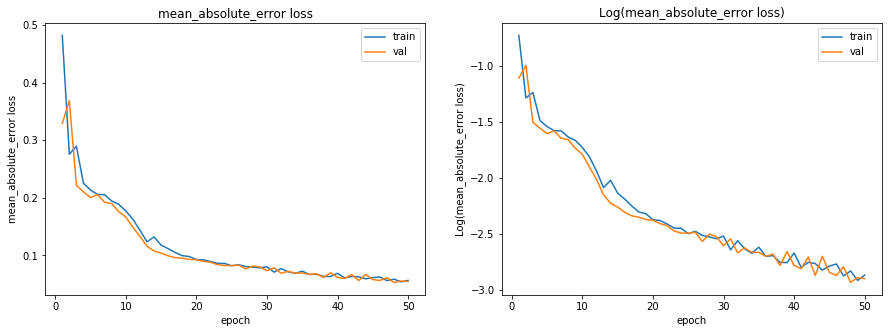

In [11]:
write_json(logs, config.LOGS_FILENAME)
logs = read_json(config.LOGS_FILENAME)

plot_loss(logs['train_loss'], logs['val_loss'], f'{config.LOSS_NAME} loss')